<a href="https://colab.research.google.com/github/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/blob/main/Capstone_I_Using_Bill_Text_To_Predict_Party_Support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone I Project - Using Bill Text and Titles from the United States Congress to Predict Party Support from Democrats and Republicans

By Edward Miller - CUNY Graduate Center
with assistance from Professor Mikael Vejdemo-Johansson

In [1]:
!pip install beautifulsoup4
!pip install requests

#!pip install lxml
#!pip install et_xmlfile
#!pip install xmltodict

!pip install google
!pip install nltk


!pip install sklearn
!pip install tensorflow==2.9.2'
!pip install keras==2.9.0
!pip install tensorflow-hub
# installing needed packages

#!pip install tf-models-official
#!pip install -U "tensorflow-text==2.13.*"
#use the AdamW optimizer from tensorflow/models.
#!pip install tensorflow_text
#!pip install official

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [3]:
import pandas as pd
import csv
import glob
import pathlib
import os
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
#import json
import requests
#import xmltodict
import urllib.request

import requests, zipfile
from io import BytesIO

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import keras as K

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, train_test_split

from bs4 import BeautifulSoup
#import xml.etree.cElementTree as et
from google.colab import drive
drive.mount('/content/drive')
# import packages

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# I. Gathering Data

We will start by gathering all of the bills in each chamber of Congress, leaving off the resolutions and the amendments. The first task is gathering the vote tallies for each party, as well as getting a list of bills. We will use a range of bills starting from 2010 and go up until this year.

In [4]:
path = '/content/drive/MyDrive/Capstone I Files/api_file.txt'
f = open(path, "r")
api_key = f.read()
# reading api key file

params = {
    'offset': 0,
    'api_key': api_key,
    'limit': 250
    # max limit allowed
}

Here, we will get the API key saved in another document and use it. To get an API key for this task, simply go here and request one:

https://api.congress.gov/sign-up/

You should receive your API key within a few minutes. We will also set the parameters to maximize the number of results returned at once from the website, and save this in a list of parameters to be used frequently when getting the data from the congressional website.

In [5]:
def get_bill_info(roll_call_nr, year):
  """ This function gets the vote tallies for each party, as well as getting a list of bills
  by entering the roll call number and the year into the url
  Args:
    roll_call_nr: int
    year: int
  Returns:
    list
  """

  rollcall_request = requests.get(f"https://clerk.house.gov/evs/{year}/roll{rollcall_nr:03}.xml")
  status = rollcall_request.status_code
  if status == 429:
    while status == 429:
      print("Response code -", status)
      start_wait = time.process_time()
      end_wait = start_wait + 600
      print("Trying API request again in ten minutes")
      while time.process_time() < end_wait:
        pass
      rollcall_request = requests.get(f"https://clerk.house.gov/evs/{year}/roll{rollcall_nr:03}.xml")
      status = rollcall_request.status_code
  # for when maximum API limit used

  if status == 200:
    # if succesful return from the website
    rollcall = BeautifulSoup(rollcall_request.content, features="xml")
    if rollcall.find("legis-num"): # ensures legis-num is in the roll call
      bill_nr = rollcall.find("legis-num").text
      # getting the bill number
    else:
      return "not_bill"
    # returns indicator that this is not a bill

    if bill_nr[0:4] == "H R " and "res" not in bill_nr.lower():
      url = f"https://api.congress.gov/v3/bill/{rollcall.congress.text}/hr/{bill_nr[5:]}/?format=xml"
    elif bill_nr[0:2] == "S "and "res" not in bill_nr.lower():
      url = f"https://api.congress.gov/v3/bill/{rollcall.congress.text}/s/{bill_nr[3:]}/?format=xml"
    # using the url based on when this is the house or senate
    else:
      return "not_bill"
    # returns indicator that this is not a bill

    congress_num = rollcall.congress.text
    # getting the congress number
    bill_request = requests.get(url, params=params)
    bill = BeautifulSoup(bill_request.content, features="xml")
    Vote_Totals = [(tbp.party.text, tbp.find("yea-total").text,
                    tbp.find("nay-total").text) for tbp in rollcall.find_all("totals-by-party")]
    for vote in Vote_Totals:
      if vote[0] == "Republican": # gets yes/no votes for Republicans
        R_Y = vote[1]
        R_N = vote[2]
      elif vote[0] == "Democratic": # gets yes/no votes for Democrats
        D_Y =  vote[1]
        D_N = vote[2]
      else:               # gets yes/no votes for Independents and other parties
        I_Y =  vote[1]
        I_N = vote[2]
    return [bill_nr, roll_call_nr, year, congress_num, R_Y, R_N, D_Y, D_N, I_Y, I_N]
  else:
    return "done"
    # returns indicator that the roll call is over

## Gathering vote tallies

Now to loop through each roll call in each year from 2010-2024 and get the vote tallies from each roll call.

In [ ]:
years = range(2010, 2025)
# initialize list of years to check bill votes
bill_votes = []
# initialize list of bill votes
for year in years:
  # looping through range of years above
  rollcall_nr = 1
  # start roll call number
  bill_info = get_bill_info(rollcall_nr, year)
  # calling bill_info function
  while bill_info != "done":
    rollcall_nr += 1
    bill_info = get_bill_info(rollcall_nr, year)
    # calling bill_info function
    if bill_info != "done" and bill_info != "not_bill" and bill_info != "none_type":
      bill_votes.append(bill_info)
  if bill_info == "done":
    print("Done for year {year}".format(year=year))
# NOTE - Takes about an hour to run

In [ ]:
df = pd.DataFrame(bill_votes, columns=["Bill Number",
                                       "Roll Call Number",
                                       "Year",
                                       "Congress Number",
                                       "Republican Yes",
                                       "Republican No",
                                       "Democratic Yes",
                                       "Democratic No",
                                       "Other Yes",
                                       "Other No"])
# creating dataframe from list of lists
display(df)
# looking at data frame

In [ ]:
display(df.shape)
print(df.nunique())
# looking at shape and unique values

## Filtering vote tallies

Now we need to get only the final vote tallies for each bill. There should only be the same number of rows as there are bills.

In [ ]:
def get_highest_roll_call(group):
    return group.loc[group['Roll Call Number'].idxmax()]
    # returns the row with the highest roll call number

df_bills = df.groupby('Bill Number', as_index=False)\
.apply(get_highest_roll_call)\
.sort_values(by=['Year','Roll Call Number'])\
.reset_index(drop=True)
# Using the sorting function and resetting index

display(df_bills)
print(df_bills.nunique())
# looking at data frame

In [ ]:
filename = "house_votes.csv"
pd.DataFrame(df_bills).to_csv(filename, index=False)
# saving data frame to csv file

## CSV File 1 - "house_votes.csv"

We now have the number of rows equal to the number of unique values for bill number, so we now have only the final tallies for each bill. Saving all of the bills into a CSV file called *house_votes.csv* to prevent need for running multiple times. The bills start from the beginning 2010 up until May 2024. In order to easily retrieve the CSV, we will save it here in a Github repository.

https://github.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text


In [8]:
url = 'https://raw.githubusercontent.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/main/house_votes.csv'
df2 = pd.read_csv(url)
# reading csv file from Github repository
display(df2)
print(df2.nunique())
# looking at data frame

,Bill Number,Roll Call Number,Year,Congress Number,Republican Yes,Republican No,Democratic Yes,Democratic No,Other Yes,Other No
0,H R 3892,5,2010,111,151,1,205,0,0,0
1,H R 3538,11,2010,111,164,4,61,187,0,0
2,H R 3254,12,2010,111,14,153,240,5,0,0
3,H R 3342,13,2010,111,15,149,234,4,0,0
4,H R 730,16,2010,111,155,9,242,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2178,H R 764,169,2024,118,205,4,4,201,0,0
2179,H R 3195,171,2024,118,210,0,2,203,0,0
2180,H R 6090,172,2024,118,187,21,133,70,0,0
2181,H R 6285,174,2024,118,209,1,5,198,0,0


Bill Number         2183
Roll Call Number     754
Year                  15
Congress Number        8
Republican Yes       214
Republican No        205
Democratic Yes       229
Democratic No        187
Other Yes              2
Other No               3
dtype: int64


## Setting Party Voting Thresholds

Now for each congress number, there needs to be thresholds set for *none*, *little*, *moderate*, and *strong* support for each party. Although *none* can be just set to zero for each party, due to the changing sizes of the parties for each congress, different thresholds need to be set for each congress, using the number of votes for each year.

In [ ]:
Republican_Support = []
Democratic_Support = []
# initializing lists

congress_numbers = range(111,119)
# initialize list of congresses to check bill votes

for congress in congress_numbers:
  # looping through range of congresses above
  R_y = sorted(list(set(df2.loc[df2['Congress Number']==congress]
   ['Republican Yes'].to_list())))
  D_y = sorted(list(set(df2.loc[df2['Congress Number']==congress]
   ['Democratic Yes'].to_list())))
  # getting unique values for each party

  max_support_R = R_y[-1]
  max_support_D = D_y[-1]
  # max values

  R_threshold_lower = max_support_R//3
  R_threshold_upper = max_support_R*2//3
  D_threshold_lower = max_support_D//3
  D_threshold_upper = max_support_D*2//3
  # getting indexes for cutoff ranges

  no_R_support = 0
  no_D_support = 0
  little_R_support = range(1,R_threshold_lower)
  little_D_support = range(1,D_threshold_lower)
  moderate_R_support = range(R_threshold_lower,R_threshold_upper)
  moderate_D_support = range(D_threshold_lower,D_threshold_upper)
  strong_R_support = range(R_threshold_upper,max_support_R+1)
  strong_D_support = range(D_threshold_upper,max_support_D+1)
  # getting ranges for support by both parties

  R_yes_list = df2.loc[df2['Congress Number']==congress]\
   ['Republican Yes'].to_list()
  D_yes_list = df2.loc[df2['Congress Number']==congress]\
   ['Democratic Yes'].to_list()

  for R_yes, D_yes in zip(R_yes_list,D_yes_list):
    # looping through the yes votes for both party for the current congress
    if R_yes in strong_R_support:
      support_R = "strong"
    elif R_yes in moderate_R_support:
      support_R = "moderate"
    elif R_yes in little_R_support:
      support_R = "little"
    elif R_yes == no_R_support:
      support_R = "none"
    else:
      support_R = "error"

    # saving republican support
    if D_yes in strong_D_support:
      support_D = "strong"
    elif D_yes in moderate_D_support:
      support_D = "moderate"
    elif D_yes in little_D_support:
      support_D = "little"
    elif D_yes == no_D_support:
      support_D = "none"
    else:
      support_D = "error"
    # saving democratic support
    Republican_Support.append(support_R)
    Democratic_Support.append(support_D)
    # adding to the list

df2['Republican Support'] = Republican_Support
df2['Democratic Support'] = Democratic_Support
# adding support columns to dataframe

In [ ]:
df2.head()

## Creating a dictionary for congressional support 2010-2024

It would be good to create a dictionary and functions for later use as well.

In [ ]:
Congress_Thresholds = []
congress_numbers = range(111,119)
# initialize list of congresses to check bill votes

for congress in congress_numbers:

  R_y = sorted(list(set(df2.loc[df2['Congress Number']==congress]
   ['Republican Yes'].to_list())))
  D_y = sorted(list(set(df2.loc[df2['Congress Number']==congress]
   ['Democratic Yes'].to_list())))
  # getting unique values for each party

  max_support_R = R_y[-1]
  max_support_D = D_y[-1]
  # max values

  R_threshold_lower = max_support_R//3
  R_threshold_upper = max_support_R*2//3
  D_threshold_lower = max_support_D//3
  D_threshold_upper = max_support_D*2//3
  # getting indexes for cutoff ranges

  no_R_support = 0
  no_D_support = 0
  little_R_support = range(1,R_threshold_lower)
  little_D_support = range(1,D_threshold_lower)
  moderate_R_support = range(R_threshold_lower,R_threshold_upper)
  moderate_D_support = range(D_threshold_lower,D_threshold_upper)
  strong_R_support = range(R_threshold_upper,max_support_R+1)
  strong_D_support = range(D_threshold_upper,max_support_D+1)
  # getting ranges for support by both parties

  support_dict = {'no_R_support':no_R_support,
                  'no_D_support':no_D_support,
                  'little_R_support': range(1,R_threshold_lower),
                  'little_D_support': range(1,D_threshold_lower),
                  'moderate_R_support': range(R_threshold_lower,R_threshold_upper),
                  'moderate_D_support': range(D_threshold_lower,D_threshold_upper),
                  'strong_R_support': range(R_threshold_upper,max_support_R+1),
                  'strong_D_support': range(D_threshold_upper,max_support_D+1)}
  # adding ranges to dictionary

  Congress_Thresholds.append([congress,support_dict])
  # adding dictionary to list

Congress_Thresholds = dict(Congress_Thresholds)
# making congress thresholds into a dictionary for later use

def get_support_thresholds(congress, D_yes, R_yes):
  '''Takes in a data frame, current congress and the number of
      Republican and Democratic yes votes and returns the support thresholds for
      both Republican and Democrats '''

  no_R_support, no_D_support, little_R_support,little_D_support, \
  moderate_R_support,moderate_D_support, strong_R_support,strong_D_support = Congress_Thresholds[congress]
  # getting support thresholds from dictionary

  if R_yes in strong_R_support:
      support_R = "strong"
  elif R_yes in moderate_R_support:
      support_R = "moderate"
  elif R_yes in little_R_support:
      support_R = "little"
  elif R_yes == no_R_support:
      support_R = "none"
  else:
      support_R = "error"

    # saving republican support
  if D_yes in strong_D_support:
      support_D = "strong"
  elif D_yes in moderate_D_support:
      support_D = "moderate"
  elif D_yes in little_D_support:
      support_D = "little"
  elif D_yes == no_D_support:
      support_D = "none"
  else:
      support_D = "error"
    # saving democratic support

  return (support_R, support_D)

In [ ]:
display(Congress_Thresholds)

Since we are interested in just the congresses from 111 to 118, we will save the output of this dictionary for continued usage in the project.

In [ ]:
congress_thresholds_dict = {111: {'no_R_support': 0,
  'no_D_support': 0,
  'little_R_support': range(1, 59),
  'little_D_support': range(1, 84),
  'moderate_R_support': range(59, 118),
  'moderate_D_support': range(84, 168),
  'strong_R_support': range(118, 178),
  'strong_D_support': range(168, 254)},
 112: {'no_R_support': 0,
  'no_D_support': 0,
  'little_R_support': range(1, 80),
  'little_D_support': range(1, 63),
  'moderate_R_support': range(80, 160),
  'moderate_D_support': range(63, 127),
  'strong_R_support': range(160, 241),
  'strong_D_support': range(127, 192)},
 113: {'no_R_support': 0,
  'no_D_support': 0,
  'little_R_support': range(1, 77),
  'little_D_support': range(1, 66),
  'moderate_R_support': range(77, 154),
  'moderate_D_support': range(66, 132),
  'strong_R_support': range(154, 232),
  'strong_D_support': range(132, 199)},
 114: {'no_R_support': 0,
  'no_D_support': 0,
  'little_R_support': range(1, 82),
  'little_D_support': range(1, 62),
  'moderate_R_support': range(82, 164),
  'moderate_D_support': range(62, 124),
  'strong_R_support': range(164, 247),
  'strong_D_support': range(124, 188)},
 115: {'no_R_support': 0,
  'no_D_support': 0,
  'little_R_support': range(1, 79),
  'little_D_support': range(1, 64),
  'moderate_R_support': range(79, 158),
  'moderate_D_support': range(64, 128),
  'strong_R_support': range(158, 239),
  'strong_D_support': range(128, 193)},
 116: {'no_R_support': 0,
  'no_D_support': 0,
  'little_R_support': range(1, 65),
  'little_D_support': range(1, 78),
  'moderate_R_support': range(65, 130),
  'moderate_D_support': range(78, 156),
  'strong_R_support': range(130, 197),
  'strong_D_support': range(156, 236)},
 117: {'no_R_support': 0,
  'no_D_support': 0,
  'little_R_support': range(1, 70),
  'little_D_support': range(1, 74),
  'moderate_R_support': range(70, 140),
  'moderate_D_support': range(74, 148),
  'strong_R_support': range(140, 212),
  'strong_D_support': range(148, 223)},
 118: {'no_R_support': 0,
  'no_D_support': 0,
  'little_R_support': range(1, 73),
  'little_D_support': range(1, 70),
  'moderate_R_support': range(73, 146),
  'moderate_D_support': range(70, 140),
  'strong_R_support': range(146, 221),
  'strong_D_support': range(140, 212)}}

  # saving dictionary of congress thresholds for later use

In [ ]:
display(df2)
print(df2.nunique())
# looking at data frame

In [ ]:
display(df2['Republican Support'].value_counts())
# looking at support
print("")
display(df2['Democratic Support'].value_counts())
# looking at support

condition = (df2['Republican Support'] == 'strong') & (df2['Democratic Support'] == 'strong')
display(df2.loc[condition])
# looking at bills supported by both parties

condition = (df2['Republican Support'] == 'strong') & (df2['Democratic Support'] == 'none')
display(df2.loc[condition])
# looking at bills supported strongly by Republicans and by no Democrats

condition = (df2['Republican Support'] == 'none') & (df2['Democratic Support'] == 'strong')
display(df2.loc[condition])
# looking at bills supported strongly by Democrats and by no Republicans


## Getting titles for congressional bills

The next step is to get the titles and text associated with each bill.

In [ ]:
def remove_extra_lines_from_string(string):
  """
  Args: string
  Returns: string
  Removes extra lines and space from beginning and end of string
  """
  i = 0
  for char in string:
    if char != "\n" and char != " ":
      break
    i += 1
  string = string[i:]
  # Removes extra lines and space from beginning

  i = 0
  for char in string[::-1]:
    if char != "\n" and char != " ":
      break
    i += 1
  string = string[:-i]
  # Removes extra lines and space from end
  return string

def get_bill_title(bill_number, congress_number):
  ''' Takes in the congress number, the chamber of congress, and the bill number
      and returns the title associated with that bill
  '''
  if bill_number[0:4] == "H R ":
    bill_num = bill_number[4:]
    title_url = f'https://api.congress.gov/v3/bill/{congress_number}/hr/{bill_num}/titles'
  elif bill_number[0:2] == "S ":
    bill_num = bill_number[2:]
    title_url = f'https://api.congress.gov/v3/bill/{congress_number}/s/{bill_num}/titles'
  # getting url depending on whether its a house or sentate bill

  response_bill_titles = requests.get(title_url, params=params, headers={'accept': 'application/xml'})
  soup = BeautifulSoup(response_bill_titles.content, features="xml")
  # getting data from congress api
  titles = soup.find_all('title')
  bill_title = titles[0].text
  bill_title = remove_extra_lines_from_string(bill_title)
  # removing extra lines and spaces from bill title

  return bill_title


In [ ]:
bill_list = df2['Bill Number'].to_list()
congress_list = df2['Congress Number'].to_list()
bill_titles = []

for bill_number, congress_number in zip(bill_list, congress_list):
  # looping through bills in data frame to get titles
  bill_title = get_bill_title(bill_number, congress_number)
  bill_titles.append(bill_title)
  # isolating most recent title and adding it to the list

df2['Bill Title'] = bill_titles
# adding bill title to data frame

# NOTE- About 15 minutes to run

In [ ]:
display(df2.head())
# looking at data frame

In [ ]:
display(df2['Bill Title'][2153])
# checking random bill title

We now have the titles for the bills, and again it would be a good idea to our progress in a CSV file called *house_vote_thresholds.csv*, so that we can avoid rerunning earlier code again. Again, in order to easily retrieve the CSV, we will save it here in a Github repository.

https://github.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text

## CSV File 2 - "house_vote_thresholds.csv"

In [ ]:
filename = "house_vote_thresholds.csv"
pd.DataFrame(df2).to_csv(filename, index=False)
# saving data frame to csv file

In [9]:
url = 'https://raw.githubusercontent.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/main/house_vote_thresholds.csv'
df3 = pd.read_csv(url)
# reading csv file from Github repository
display(df3)
print(df3.nunique())
# looking at data frame

,Bill Number,Roll Call Number,Year,Congress Number,Republican Yes,Republican No,Democratic Yes,Democratic No,Other Yes,Other No,Republican Support,Democratic Support,Bill Title
0,H R 3892,5,2010,111,151,1,205,0,0,0,strong,strong,To designate the facility of the United States...
1,H R 3538,11,2010,111,164,4,61,187,0,0,strong,little,Idaho Wilderness Water Facilities Act
2,H R 3254,12,2010,111,14,153,240,5,0,0,little,strong,Taos Pueblo Indian Water Rights Settlement Act
3,H R 3342,13,2010,111,15,149,234,4,0,0,little,strong,Aamodt Litigation Settlement Act
4,H R 730,16,2010,111,155,9,242,1,0,0,strong,strong,Nuclear Forensics and Attribution Act
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,H R 764,169,2024,118,205,4,4,201,0,0,strong,little,Trust the Science Act
2179,H R 3195,171,2024,118,210,0,2,203,0,0,strong,little,Superior National Forest Restoration Act
2180,H R 6090,172,2024,118,187,21,133,70,0,0,strong,moderate,Antisemitism Awareness Act of 2023
2181,H R 6285,174,2024,118,209,1,5,198,0,0,strong,little,Alaska’s Right to Produce Act of 2023


Bill Number           2183
Roll Call Number       754
Year                    15
Congress Number          8
Republican Yes         214
Republican No          205
Democratic Yes         229
Democratic No          187
Other Yes                2
Other No                 3
Republican Support       4
Democratic Support       4
Bill Title            2122
dtype: int64


## Checking duplicate bill titles

There are some duplicates for the bill title column,
so this should be investigated before adding in the text columns. If both the title and text are duplicated for a row, these duplicates should be removed

In [ ]:
condition = df3.duplicated(subset='Bill Title', keep=False)==True
# setting keep to False allows for both and the originals to be shown
duplicates = df3[condition]
display(duplicates)
# looking at the bills with duplicate titles

In [ ]:
duplicate_bill_titles = set(duplicates['Bill Title'].to_list())
for title in duplicate_bill_titles:
  display(duplicates[duplicates['Bill Title']==title])
# looking at the bills with duplicate titles

There are some duplicate titles also with varying degrees of party support between the duplicates, so it would be short-sighted to just remove the duplicates right away, as the text of the bills might be different.

## Getting text for congressional bills

Now to get the text for each bill. We are interested in the setions after the headers, which usually contain two long lines for House bills and 3 new lines for Senate bills. We will remove those and then save the text.

In [ ]:
def get_text_body(text):
    ''' Removes headers from text
    '''
    string_break = '\n_______________________________________________________________________\n'
    string_break2 = '\n\n\n \n'

    first_index = text.find(string_break)
    text = text[first_index+len(string_break):]
    # gets text after first string break
    second_index = text.find(string_break)
    # gets text after second string break
    text = text[second_index+len(string_break):]
    third_index = text.find(string_break2)
    # gets text after third string break
    text = text[third_index+len(string_break2):]

    return text

def extract_text(url2):
  ''' Takes in a url and returns the text associated with that bill
  '''
  response = requests.get(url2.strip(), params=params, headers={'accept': 'application/htm'}, allow_redirects=False)
  #status = response.status_code
  if (response.ok):
    soup = BeautifulSoup(response.content, features="html")
    for script in soup(["script", "style"]):
      script.extract()
    # removes all script and style elements
    text = soup.get_text()
    # get text out of url
    text = get_text_body(text)
    # get text out of url
    return text
    #return text_content
  else:
    return ""

def get_bill_text(congress,chamber,bill_number):
  ''' Takes in the congress number, the chamber of congress, and the bill number
      and returns the text associated with that bill
  '''
  url = f"https://api.congress.gov/v3/bill/{congress}/{chamber}/{bill_number}/text"
  response_bill_text = requests.get(url, params=params, headers={'accept': 'application/xml'})
  status = response_bill_text.status_code
  #print(status)
  if status == 429:
    while status == 429:
      print("Response code -", status)
      start_wait = time.process_time()
      end_wait = start_wait + 600
      print("Trying API request again in ten minutes")
      while time.process_time() < end_wait:
        pass
      response_bill_text = requests.get(url, params=params, headers={'accept': 'application/xml'})
      status = response_bill_text.status_code
  # for when maximum API limit used
  text_soup = BeautifulSoup(response_bill_text.content, features="xml")
  if text_soup.find_all("url") == []:
    return None
  # if there is no url, return none
  text_url = str(text_soup.find_all("url")[0].text)
  # get the most recent url from the api to extract bill text from
  if 'htm' not in text_url:
    for url in text_soup.find_all("url"):
      if '.htm' in str(url):
        text_url = str(url)
        break
    # if htm not the extension find the url with the htm extension
  text_content = extract_text(text_url)
  # call function to get text out of url
  return text_content

test_txt = get_bill_text(115,'s',35)
print(test_txt)
# testing with random bill

#H R 4416

In [ ]:
house_url = 'https://www.congress.gov/114/bills/hr4416/BILLS-114hr4416rfs.htm'
senate_url = 'https://www.congress.gov/115/bills/s35/BILLS-115s35enr.htm'

test_extract = extract_text(house_url)
print((test_extract))
# testing extract_text function

In [ ]:
bill_list = df3['Bill Number'].to_list()
congress_list = df3['Congress Number'].to_list()
bill_text_list = []

for bill_number, congress_number in zip(bill_list, congress_list):
  # looping through bills in data frame to get bill text

  if bill_number[0:4] == "H R ":
    bill_num = bill_number[4:]
    chamber = 'hr'
  elif bill_number[0:2] == "S ":
    bill_num = bill_number[2:]
    chamber = 's'
  # getting chamber of congress and bill number

  text = get_bill_text(congress_number,chamber,bill_num)
  bill_text_list.append(text)
  # getting bill text

df3['Bill Text'] = bill_text_list
# adding bill text to data frame
# NOTE - this cell takes about 20 mins to run

In [ ]:
display(df3.head())
# looking at data frame

In [ ]:
print(df3.loc[df3['Bill Text']== ''].value_counts())

There are some empty spots where the bill text should be, so we will re-run the procedure to try and fill in the remaining spots

In [ ]:
for ind in df3.index:
  # looping through rows of data frame to find empty text
    if df3['Bill Text'][ind] == '' or df3['Bill Text'][ind] == None:
      bill_number = df3['Bill Number'][ind]
      if bill_number[0:4] == "H R ":
        bill_num = bill_number[4:]
        chamber = 'hr'
      elif bill_number[0:2] == "S ":
        bill_num = bill_number[2:]
        chamber = 's'
      # getting chamber of congress and bill number
      congress_no = df3['Congress Number'][ind]
      #df3['Bill Text'][ind] = get_bill_text(congress_no,chamber,bill_num)
      df3.loc[ind,'Bill Text'] = get_bill_text(congress_no,chamber,bill_num)
      # filling in empty space with bill text

# about 5 min to run

In [ ]:
print(df3.loc[df3['Bill Text']== ''].value_counts())
print(df3.loc[df3['Bill Text']== ''].value_counts().sum())
# looking at data frame

bills_needing_text = df3.loc[df3['Bill Text']== '']['Bill Number'].to_list()
print(bills_needing_text)
# looking at bills with empty text

After re-rerunning the above cell a few times and accounting for API limits of 5,000 requests per hour, there are still a few bills without text. After looking at the bills it's shown that these have a different format than the other bills, so lines from the functions above will be retooled slightly, in order to get the text for the remaining missing bill texts.

In [ ]:
for bill in bills_needing_text:
  # looping through bills with empty text
  if bill[0:4] == "H R ":
        bill_num = bill[4:]
        chamber = 'hr'
  elif bill[0:2] == "S ":
        bill_num = bill[2:]
        chamber = 's'
  # getting chamber of congress and bill number
  congress_no = df3.loc[df3['Bill Number']==bill]['Congress Number'].values[0]
  # getting congress number
  url = f"https://api.congress.gov/v3/bill/{congress}/{chamber}/{bill_number}/text"
  response = requests.get(url, params=params, headers={'accept': 'application/xml'})
  soup = BeautifulSoup(response.content, features="xml")
  text_url = str(soup.find_all("url")[0].text)
  # get text url
  if 'htm' not in text_url:
    for url in soup.find_all("url"):
      if '.htm' in str(url):
        text_url = str(url)
        break
  # if there is no url, return none
  response = requests.get(text_url.strip(), params=params, headers={'accept': 'application/htm'}, allow_redirects=False)
  soup = BeautifulSoup(response.content, features="html")
  # get response from text url
  for script in soup(["script", "style"]):
      script.extract()
    # removes all script and style elements
  text = soup.get_text()
  string_break3 = 'AMENDMENT:\n\n            Strike out all after the enacting clause and insert:\n\nSECTION 1. SHORT TITLE; TABLE OF CONTENTS.\n\n'
  fourth_index = text.find(string_break3)
  # gets text after fourth string break
  t=text[fourth_index+len(string_break3):]
  df3.loc[df3['Bill Number']==bill,'Bill Text'] = t
  # removes header from text


In [ ]:
print(df3.loc[df3['Bill Text']== ''].value_counts())
print(df3.loc[df3['Bill Text']== ''].value_counts().sum())
# looking at data frame

Now there are no more bills with empty text

In [ ]:
print(df3.nunique())
# looking at data frame

In [ ]:
condition = df3.duplicated(subset=['Bill Title','Bill Text'], keep=False)==True
# setting keep to False allows for both and the originals to be shown
duplicates = df3[condition]
display(duplicates)
# looking at the bills with duplicate titles

There are some duplicates for the title and the text individually, but none together, so none of the duplicates will be removed here. Now to save the data frame containing both the title and the text for each bill into a csv file called *house_vote_full.csv* for later retrieval

## CSV File 3 - "house_vote_full.csv"

In [ ]:
filename = "house_vote_full.csv"
pd.DataFrame(df3).to_csv(filename, index=False)
# saving data frame to csv file

#### Uploading a large file to Github

This will also be saved as a .zip file in Github in a folder here, https://github.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/tree/main , as the file is too large to add to Github as is.

**NOTE:** Github will allow a file of up to *25 MB* in size to be dragged and dropped into the repository, and up to *100 MB* if the file is added via the command line or Github Desktop. The .zip file is still larger than *25 MB*, so it'll need to be saved into local storage and uploaded via the command line in the terminal to be added into the Github repository.

Detailed instructions on how to do so can be found here:

https://docs.github.com/en/repositories/working-with-files/managing-files/adding-a-file-to-a-repository#adding-a-file-to-a-repository-using-the-command-line


**SPECIAL NOTE:** Before following the above instructions, **READ THIS FIRST**. -->
In order to upload files to a Github repository from the command line, it is necessary to use an **SSH** key, and also clone the Github repository using the **SSH** option. To create a new SSH key, follow these instructions:

https://docs.github.com/en/authentication/connecting-to-github-with-ssh/generating-a-new-ssh-key-and-adding-it-to-the-ssh-agent

and follow THESE instructions to add the **SSH** key to the Github account:

https://docs.github.com/en/authentication/connecting-to-github-with-ssh/adding-a-new-ssh-key-to-your-github-account


Otherwise, the *'git push origin main'* command will cause authentication errors, and the file will not be uploaded.


Now that the file is saved in Github, it will be retrieved, unzipped, and saved as **df4**.

In [10]:
file_url = 'https://raw.githubusercontent.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/main/house_vote_full.csv.zip'
r = requests.get(file_url)
z = zipfile.ZipFile(BytesIO(r.content))
z.extractall()
# downloading zipped csv file from github
file = z.namelist()[0]
# saving file name
df4 = pd.read_csv('/content/' + file)
# reading csv file into data frame
display(df4)
print(df4.nunique())
# looking at data frame

,Bill Number,Roll Call Number,Year,Congress Number,Republican Yes,Republican No,Democratic Yes,Democratic No,Other Yes,Other No,Republican Support,Democratic Support,Bill Title,Bill Text
0,H R 3892,5,2010,111,151,1,205,0,0,0,strong,strong,To designate the facility of the United States...,To designate the facility of the United States...
1,H R 3538,11,2010,111,164,4,61,187,0,0,strong,little,Idaho Wilderness Water Facilities Act,To authorize the continued use of certain wat...
2,H R 3254,12,2010,111,14,153,240,5,0,0,little,strong,Taos Pueblo Indian Water Rights Settlement Act,To approve the Taos Pueblo Indian Water Right...
3,H R 3342,13,2010,111,15,149,234,4,0,0,little,strong,Aamodt Litigation Settlement Act,To authorize the Secretary of the Interior...
4,H R 730,16,2010,111,155,9,242,1,0,0,strong,strong,Nuclear Forensics and Attribution Act,To strengthen efforts in the Department of Hom...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,H R 764,169,2024,118,205,4,4,201,0,0,strong,little,Trust the Science Act,AN ACT\n\n To...
2179,H R 3195,171,2024,118,210,0,2,203,0,0,strong,little,Superior National Forest Restoration Act,"To rescind Public Land Order 7917, to reinst..."
2180,H R 6090,172,2024,118,187,21,133,70,0,0,strong,moderate,Antisemitism Awareness Act of 2023,AN ACT\n\n To pr...
2181,H R 6285,174,2024,118,209,1,5,198,0,0,strong,little,Alaska’s Right to Produce Act of 2023,AN ACT\n\n To ...


Bill Number           2183
Roll Call Number       754
Year                    15
Congress Number          8
Republican Yes         214
Republican No          205
Democratic Yes         229
Democratic No          187
Other Yes                2
Other No                 3
Republican Support       4
Democratic Support       4
Bill Title            2122
Bill Text             2163
dtype: int64


In [5]:
print(df4['Bill Text'].isna().sum())
# comparing number of Nas for data frame

1


Before proceeding with the next steps, it would be good to remove all of the excess spaces and new lines from the 'Bill Text' column

In [6]:
def remove_extra_lines_from_string(s):
  """
  Args: string
  Returns: string
  Removes extra lines and space from beginning and end of string
  """
  if isinstance(s,str):
    s = s.replace("\n","") # remove new lines
    s = s.strip() # remove leading and trailing spaces
    s = re.sub(' +', ' ', s) # remove multiple spaces
  return s

df4['Bill Text'] = df4['Bill Text'].apply(remove_extra_lines_from_string)
# removing extra lines and spaces from bill text

In [7]:
display(df4.head())
# looking at data frame

,Bill Number,Roll Call Number,Year,Congress Number,Republican Yes,Republican No,Democratic Yes,Democratic No,Other Yes,Other No,Republican Support,Democratic Support,Bill Title,Bill Text
0,H R 3892,5,2010,111,151,1,205,0,0,0,strong,strong,To designate the facility of the United States...,To designate the facility of the United States...
1,H R 3538,11,2010,111,164,4,61,187,0,0,strong,little,Idaho Wilderness Water Facilities Act,To authorize the continued use of certain wate...
2,H R 3254,12,2010,111,14,153,240,5,0,0,little,strong,Taos Pueblo Indian Water Rights Settlement Act,To approve the Taos Pueblo Indian Water Rights...
3,H R 3342,13,2010,111,15,149,234,4,0,0,little,strong,Aamodt Litigation Settlement Act,"To authorize the Secretary of the Interior, ac..."
4,H R 730,16,2010,111,155,9,242,1,0,0,strong,strong,Nuclear Forensics and Attribution Act,To strengthen efforts in the Department of Hom...


Now the data in **'Bill Text'** column looks a little cleaner, and should take up a little less space.

## Establishing Support Classes for party support

Since there are no duplicates for the titles and the text, the Na's will be left. Now that the data frame has the title and text and thresholds for Democratic and Republican support, it's time to establish the different classes for classification, and split the data. There are 16 different classes in total with the lowest number corresponding with the least amount of support from Republicans and the lowest number modulo 4 represeting the least amount of support from Democrats

In [32]:
def create_support_class(R,D):
  '''
    Args:
      R - A string from the following set that represents the support class of the bill
          {none, little, moderate, strong}

      D - A string from the following set that represents the support class of the bill
          {none, little, moderate, strong}
    Returns:
      support_class - an integer between 0 and 15 that represents the support class
      the higher the number, the more Republican support the bill has
      the higher the number modulo 4, the more Democratic support the bill has
  '''

  if R == 'none' and D == 'none':
    support_class = 0
  if R == 'none' and D == 'little':
    support_class = 1
  if R == 'none' and D == 'moderate':
    support_class = 2
  if R == 'none' and D == 'strong':
    support_class = 3
  # classes 0 - 3 have no Republican support
  if R == 'little' and D == 'none':
    support_class = 4
  if R == 'little' and D == 'little':
    support_class = 5
  if R == 'little' and D == 'moderate':
    support_class = 6
  if R == 'little' and D == 'strong':
    support_class = 7
  # classes 4 - 7 have little Republican Support
  if R == 'moderate' and D == 'none':
    support_class = 8
  if R == 'moderate' and D == 'little':
    support_class = 9
  if R == 'moderate' and D == 'moderate':
    support_class = 10
  if R == 'moderate' and D == 'strong':
    support_class = 11
  # classes 8 - 11 have moderate Republican Support
  if R == 'strong' and D == 'none':
    support_class = 12
  if R == 'strong' and D == 'little':
    support_class = 13
  if R == 'strong' and D == 'moderate':
    support_class = 14
  if R == 'strong' and D == 'strong':
    support_class = 15
  # classes 12 - 15 have strong Republican Support

  return support_class

support_class_dict = {0:['none','none'],
                      1:['none','little'],
                      2:['none','moderate'],
                      3:['none','strong'],
                      4:['little','none'],
                      5:['little','little'],
                      6:['little','moderate'],
                      7:['little','strong'],
                      8:['moderate','none'],
                      9:['moderate','little'],
                      10:['moderate','moderate'],
                      11:['moderate','strong'],
                      12:['strong','none'],
                      13:['strong','little'],
                      14:['strong','moderate'],
                      15:['strong','strong']}
# Republican support is the first value, Democratic Support is the second

In [33]:
print("Support Class Dictionary\n")
for key, value in support_class_dict.items():
  print(key, value)
# looking at support class dictionary

print("\nSupport class - 0\n", support_class_dict[0])
# looking at the values for class 0
print("\nSupport class - 15\n", support_class_dict[15])
# looking at the values for class 15

Support Class Dictionary

0 ['none', 'none']
1 ['none', 'little']
2 ['none', 'moderate']
3 ['none', 'strong']
4 ['little', 'none']
5 ['little', 'little']
6 ['little', 'moderate']
7 ['little', 'strong']
8 ['moderate', 'none']
9 ['moderate', 'little']
10 ['moderate', 'moderate']
11 ['moderate', 'strong']
12 ['strong', 'none']
13 ['strong', 'little']
14 ['strong', 'moderate']
15 ['strong', 'strong']

Support class - 0
 ['none', 'none']

Support class - 15
 ['strong', 'strong']


In [34]:
df4['Support Class'] = df4.apply(lambda x: create_support_class(x['Republican Support'],
                                                                x['Democratic Support']), axis=1)
# adding numerical representations of class into dataframe
df4.head()
# looking at data frame with extra support class

,Bill Number,Roll Call Number,Year,Congress Number,Republican Yes,Republican No,Democratic Yes,Democratic No,Other Yes,Other No,Republican Support,Democratic Support,Bill Title,Bill Text,Support Class
0,H R 3892,5,2010,111,151,1,205,0,0,0,strong,strong,To designate the facility of the United States...,To designate the facility of the United States...,15
1,H R 3538,11,2010,111,164,4,61,187,0,0,strong,little,Idaho Wilderness Water Facilities Act,To authorize the continued use of certain wate...,13
2,H R 3254,12,2010,111,14,153,240,5,0,0,little,strong,Taos Pueblo Indian Water Rights Settlement Act,To approve the Taos Pueblo Indian Water Rights...,7
3,H R 3342,13,2010,111,15,149,234,4,0,0,little,strong,Aamodt Litigation Settlement Act,"To authorize the Secretary of the Interior, ac...",7
4,H R 730,16,2010,111,155,9,242,1,0,0,strong,strong,Nuclear Forensics and Attribution Act,To strengthen efforts in the Department of Hom...,15


In [35]:
display(df4['Support Class'].value_counts())
# looking at the distribution of support classes

Support Class
15    1348
13     372
7      188
11     112
14      81
12      39
3       31
9        4
10       3
6        2
2        1
8        1
5        1
Name: count, dtype: int64

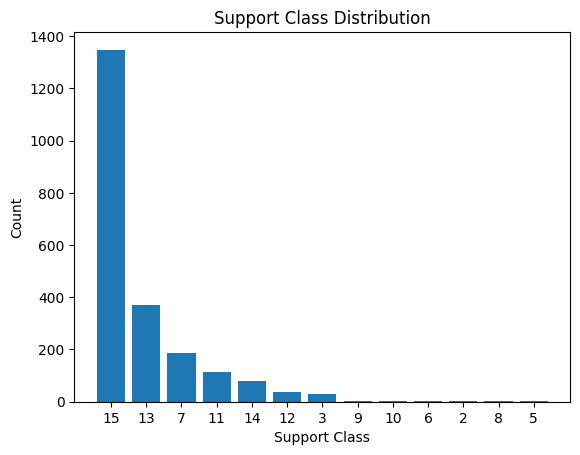

In [36]:
support_class_dist = df4['Support Class'].value_counts().to_dict()
names = list(support_class_dist.keys())
values = list(support_class_dist.values())
plt.bar(range(len(support_class_dist)), values, tick_label=names)
plt.title('Support Class Distribution')
plt.xlabel('Support Class')
plt.ylabel('Count')
plt.show()
# looking at the distribution of support classes




---
**3** classes have no instances in the data set at all:



---




*   **0 - ['none', 'none']**
*   **1 - ['none', 'little']**
*   **4 - ['little', 'none']**




---



and another **6** classes have less than five instances each


---



* **9 - ['moderate', 'little']  with 4 instances**

* **10 - ['moderate', 'moderate'] with 3 instances**

* **6 - ['little', 'moderate'] with 2 instances**

* **2 - ['none', 'moderate'] with 1 instance**

* **8 - ['moderate', 'none'] with 1 instance**

* **5 - ['little', 'little'] with 1 instance**


---



The remaining **7** classes are as follows:

---

* **15 - ['strong', 'strong'] with 1348 instances**

* **13 - ['strong', 'little'] with 372 instances**

* **7 -  ['little', 'strong'] with 188 instances**

* **11 - ['moderate', 'strong'] with 112 instances**

* **14 - ['strong', 'moderate'] with 81 instances**

* **12 - ['strong', 'none'] with 39 instances**

* **3 -  ['none', 'strong']  with 31 instances**

## Updating Party Voting Thresholds and Support Classes for Party Support

The above distribution of the classes shows a skewed distribution heavily in favor of **class 15**, which is strong support from both Republican and Democratic parties, and also suggests that the class structure needs a retooling. For one, the **'none'** support class for each party doesn't seem to have enough instances to warrant its continued use, and therefore, it seems prudent to merge the **'none'** support class into the **'little'** support classs. Also, one notices that the vast majority of the bills have strong support from at least one party. Therefore, the classes should be reorganized into the following new classes:

* **0 - Not strongly supported by either party**

* **1 - little support from Republicans, strong support from Democrats**

* **2 - moderate support from Republicans, strong support from Democrats**

* **3 - strong support from Republicans, little support from Democrats**

* **4 - strong support from Republicans, moderate support from Democrats**

* **5 - strong support from both parties**

In [37]:
updated_congress_thresholds_dict = {111: {
  'little_R_support': range(0, 59),
  'little_D_support': range(0, 84),
  'moderate_R_support': range(59, 118),
  'moderate_D_support': range(84, 168),
  'strong_R_support': range(118, 178),
  'strong_D_support': range(168, 254)},
 112: {
  'little_R_support': range(0, 80),
  'little_D_support': range(0, 63),
  'moderate_R_support': range(80, 160),
  'moderate_D_support': range(63, 127),
  'strong_R_support': range(160, 241),
  'strong_D_support': range(127, 192)},
 113: {
  'little_R_support': range(0, 77),
  'little_D_support': range(0, 66),
  'moderate_R_support': range(77, 154),
  'moderate_D_support': range(66, 132),
  'strong_R_support': range(154, 232),
  'strong_D_support': range(132, 199)},
 114: {
  'little_R_support': range(0, 82),
  'little_D_support': range(0, 62),
  'moderate_R_support': range(82, 164),
  'moderate_D_support': range(62, 124),
  'strong_R_support': range(164, 247),
  'strong_D_support': range(124, 188)},
 115: {
  'little_R_support': range(0, 79),
  'little_D_support': range(0, 64),
  'moderate_R_support': range(79, 158),
  'moderate_D_support': range(64, 128),
  'strong_R_support': range(158, 239),
  'strong_D_support': range(128, 193)},
 116: {
  'little_R_support': range(0, 65),
  'little_D_support': range(0, 78),
  'moderate_R_support': range(65, 130),
  'moderate_D_support': range(78, 156),
  'strong_R_support': range(130, 197),
  'strong_D_support': range(156, 236)},
 117: {
  'little_R_support': range(0, 70),
  'little_D_support': range(0, 74),
  'moderate_R_support': range(70, 140),
  'moderate_D_support': range(74, 148),
  'strong_R_support': range(140, 212),
  'strong_D_support': range(148, 223)},
 118: {
  'little_R_support': range(0, 73),
  'little_D_support': range(0, 70),
  'moderate_R_support': range(73, 146),
  'moderate_D_support': range(70, 140),
  'strong_R_support': range(146, 221),
  'strong_D_support': range(140, 212)}}

  # NOTE - Same as previous dictionary, but with 'none' support class removed
  # and merged into 'little' support for each party

updated_support_class_dict = {0:['not strong', 'not strong'],
                      1:['little','strong'],
                      2:['moderate','strong'],
                      3:['strong','little'],
                      4:['strong','moderate'],
                      5:['strong','strong'],}
# Republican support is the first value, Democratic Support is the second

def get_updated_support_thresholds(congress, D_yes, R_yes):
  '''Takes in a data frame, current congress and the number of
      Republican and Democratic yes votes and returns the support thresholds for
      both Republican and Democrats '''

  little_R_support,little_D_support,
  moderate_R_support,moderate_D_support,
  strong_R_support,strong_D_support = Congress_Thresholds[congress]
  # getting support thresholds from dictionary

  if R_yes in strong_R_support:
      support_R = "strong"
  elif R_yes in moderate_R_support:
      support_R = "moderate"
  elif R_yes in little_R_support:
      support_R = "little"
  else:
      support_R = "error"
    # saving republican support
  if D_yes in strong_D_support:
      support_D = "strong"
  elif D_yes in moderate_D_support:
      support_D = "moderate"
  elif D_yes in little_D_support:
      support_D = "little"
  else:
      support_D = "error"
    # saving democratic support

  return (support_R, support_D)

In [38]:
for ind in df4.index:
  # looping through rows of data frame to find instances of 'none' and replace
  # with 'little'

  if df4['Republican Support'][ind]	== 'none':
    df4.loc[ind,'Republican Support'] = 'little'
  if df4['Democratic Support'][ind] == 'none':
    df4.loc[ind,'Democratic Support'] = 'little'


In [ ]:
display(df4['Republican Support'].value_counts())
display(df4['Democratic Support'].value_counts())
# looking at the distribution of support classes

The 'none' category has been replaced with 'little' throughout the dataframe, so the next task is to create an updated support classs

In [39]:
def create_updated_support_class(R,D):
  '''
    Args:
      R - A string from the following set that represents the support class of the bill
          {little, moderate, strong}

      D - A string from the following set that represents the support class of the bill
          {little, moderate, strong}
    Returns:
      support_class - an integer between 0 and 5 that represents the support class

  '''
  # 0 - Not strongly supported by either party
  # 1 - little support from Republicans, strong support from Democrats
  # 2 - moderate support from Republicans, strong support from Democrats
  # 3 - strong support from Republicans, little support from Democrats
  # 4 - strong support from Republicans, moderate support from Democrats**
  # 5 - strong support from both parties**

  if R == 'strong' and D == 'strong':
    support_class = 5
  elif R == 'strong' and D == 'moderate':
    support_class = 4
  elif R == 'strong' and D == 'little':
    support_class = 3
  elif R == 'moderate' and D == 'strong':
    support_class = 2
  elif R == 'little' and D == 'strong':
    support_class = 1
  else:
    support_class = 0
  return support_class

In [40]:
df4['Support Class'] = df4.apply(lambda x: create_updated_support_class(x['Republican Support'],
                                                                x['Democratic Support']), axis=1)
# updating numerical representations of class into dataframe
df4.head()
# looking at data frame with updated support class

,Bill Number,Roll Call Number,Year,Congress Number,Republican Yes,Republican No,Democratic Yes,Democratic No,Other Yes,Other No,Republican Support,Democratic Support,Bill Title,Bill Text,Support Class
0,H R 3892,5,2010,111,151,1,205,0,0,0,strong,strong,To designate the facility of the United States...,To designate the facility of the United States...,5
1,H R 3538,11,2010,111,164,4,61,187,0,0,strong,little,Idaho Wilderness Water Facilities Act,To authorize the continued use of certain wate...,3
2,H R 3254,12,2010,111,14,153,240,5,0,0,little,strong,Taos Pueblo Indian Water Rights Settlement Act,To approve the Taos Pueblo Indian Water Rights...,1
3,H R 3342,13,2010,111,15,149,234,4,0,0,little,strong,Aamodt Litigation Settlement Act,"To authorize the Secretary of the Interior, ac...",1
4,H R 730,16,2010,111,155,9,242,1,0,0,strong,strong,Nuclear Forensics and Attribution Act,To strengthen efforts in the Department of Hom...,5


In [41]:
display(df4['Support Class'].value_counts())
# looking at the distribution of support classes

Support Class
5    1348
3     411
1     219
2     112
4      81
0      12
Name: count, dtype: int64

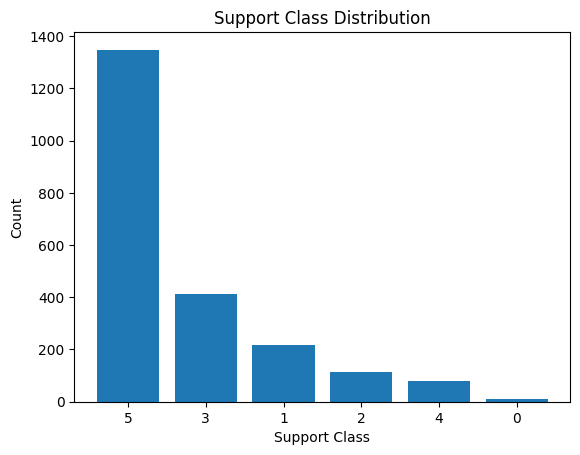

In [42]:
support_class_dist = df4['Support Class'].value_counts().to_dict()
names = list(support_class_dist.keys())
names2 = list(updated_support_class_dict.keys())
values = list(support_class_dist.values())

plt.bar(range(len(support_class_dist)), values, tick_label=names)
plt.title('Support Class Distribution')
plt.xlabel('Support Class')
plt.ylabel('Count')
plt.show()
# looking at the new distribution of support classes

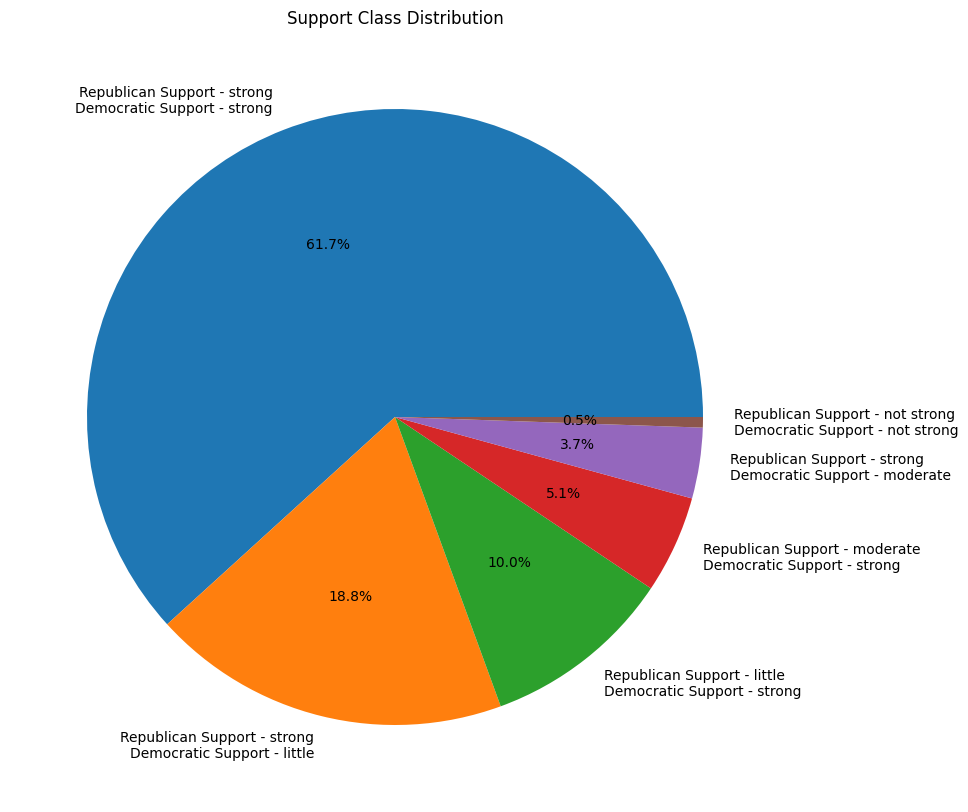

In [43]:
res = [tuple for x in names for tuple in names2 if tuple == x]
labels = []
for i in res:
  R_support = updated_support_class_dict[i][0]
  D_support = updated_support_class_dict[i][1]
  Label = "Republican Support - " + R_support + "\nDemocratic Support - " + D_support
  labels.append(Label)

plt.figure(figsize=(10,10))
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Support Class Distribution')

plt.show()
# looking at the distribution of support classes

Here one can see that the most frequent class is **5**, which is strong support from both Republican and Democrats. There are 5 other classes, 4 of which have strong support from at least one or the other party. The second and third most frequent classes, **3** and **1** are for bills that have strong support from one party and little from the other party, and the fourth and fifth most frequent classes have strong support from one party, and moderate support from the other party. The class that appears only 0.5% of the time is the class that does not have strong support from either party, which shows that a bill is highly unlikely to be introduced, unless one of the two major parties strongly supports it. Due to the skew of the classes, it may be better to use *ROC-AUC Score* rather than *accuracy* as a scoring metric when determining which class the bill text and title belong to.

Now to save the dataframe with all of the information to another CSV file, *house_vote_final.csv* for later retrieval.

## CSV File 4 - "house_vote_final.csv"

In [44]:
filename = "house_vote_final.csv"
pd.DataFrame(df4).to_csv(filename, index=False)
# saving data frame to csv file

This will also be saved as a .zip file in Github in a folder here, https://github.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/tree/main , as the file is too large to add to Github as is.

Again, the file will need to be added via the command line in the terminal using the same instructions as found earlier in this note book for the *house_vote_full.csv* (See the section **'Uploading a large file to Github'**)

After uploading the file into Github, we will retrieve it and save it as **df5**

In [12]:
file_url = 'https://raw.githubusercontent.com/EdwardMMiller/Predicting-Party-Support-From-Bill-Text/main/house_vote_final.csv.zip'
r = requests.get(file_url)
z = zipfile.ZipFile(BytesIO(r.content))
z.extractall()
# downloading zipped csv file from github
file = z.namelist()[0]
# saving file name
df5 = pd.read_csv('/content/' + file)
# reading csv file into data frame
display(df5)
print(df5.nunique())
# looking at data frame

,Bill Number,Roll Call Number,Year,Congress Number,Republican Yes,Republican No,Democratic Yes,Democratic No,Other Yes,Other No,Republican Support,Democratic Support,Bill Title,Bill Text,Support Class
0,H R 3892,5,2010,111,151,1,205,0,0,0,strong,strong,To designate the facility of the United States...,To designate the facility of the United States...,5
1,H R 3538,11,2010,111,164,4,61,187,0,0,strong,little,Idaho Wilderness Water Facilities Act,To authorize the continued use of certain wate...,3
2,H R 3254,12,2010,111,14,153,240,5,0,0,little,strong,Taos Pueblo Indian Water Rights Settlement Act,To approve the Taos Pueblo Indian Water Rights...,1
3,H R 3342,13,2010,111,15,149,234,4,0,0,little,strong,Aamodt Litigation Settlement Act,"To authorize the Secretary of the Interior, ac...",1
4,H R 730,16,2010,111,155,9,242,1,0,0,strong,strong,Nuclear Forensics and Attribution Act,To strengthen efforts in the Department of Hom...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,H R 764,169,2024,118,205,4,4,201,0,0,strong,little,Trust the Science Act,AN ACT To require the Secretary of the Interio...,3
2179,H R 3195,171,2024,118,210,0,2,203,0,0,strong,little,Superior National Forest Restoration Act,"To rescind Public Land Order 7917, to reinstat...",3
2180,H R 6090,172,2024,118,187,21,133,70,0,0,strong,moderate,Antisemitism Awareness Act of 2023,AN ACT To provide for the consideration of a d...,4
2181,H R 6285,174,2024,118,209,1,5,198,0,0,strong,little,Alaska’s Right to Produce Act of 2023,AN ACT To ratify and approve all authorization...,3


Bill Number           2183
Roll Call Number       754
Year                    15
Congress Number          8
Republican Yes         214
Republican No          205
Democratic Yes         229
Democratic No          187
Other Yes                2
Other No                 3
Republican Support       3
Democratic Support       3
Bill Title            2122
Bill Text             2163
Support Class            6
dtype: int64


## Create Functional Pipeline

Now that the data has been gathered, it would be good to put all parameters and functions together, in order to avoid rerunning entire notebook, and as a way to establish a single function pipeline where one can enter a roll call number and a year, and have the needed data returned with a single function call.

In [14]:
# All functions and paramaters together
path = '/content/drive/MyDrive/Capstone I Files/api_file.txt'
f = open(path, "r")
api_key = f.read()
# reading api key file
params = {
    'offset': 0,
    'api_key': api_key,
    'limit': 250
    # max limit allowed
}

updated_congress_thresholds_dict = {111: {
  'little_R_support': range(0, 59),
  'little_D_support': range(0, 84),
  'moderate_R_support': range(59, 118),
  'moderate_D_support': range(84, 168),
  'strong_R_support': range(118, 178),
  'strong_D_support': range(168, 254)},
 112: {
  'little_R_support': range(0, 80),
  'little_D_support': range(0, 63),
  'moderate_R_support': range(80, 160),
  'moderate_D_support': range(63, 127),
  'strong_R_support': range(160, 241),
  'strong_D_support': range(127, 192)},
 113: {
  'little_R_support': range(0, 77),
  'little_D_support': range(0, 66),
  'moderate_R_support': range(77, 154),
  'moderate_D_support': range(66, 132),
  'strong_R_support': range(154, 232),
  'strong_D_support': range(132, 199)},
 114: {
  'little_R_support': range(0, 82),
  'little_D_support': range(0, 62),
  'moderate_R_support': range(82, 164),
  'moderate_D_support': range(62, 124),
  'strong_R_support': range(164, 247),
  'strong_D_support': range(124, 188)},
 115: {
  'little_R_support': range(0, 79),
  'little_D_support': range(0, 64),
  'moderate_R_support': range(79, 158),
  'moderate_D_support': range(64, 128),
  'strong_R_support': range(158, 239),
  'strong_D_support': range(128, 193)},
 116: {
  'little_R_support': range(0, 65),
  'little_D_support': range(0, 78),
  'moderate_R_support': range(65, 130),
  'moderate_D_support': range(78, 156),
  'strong_R_support': range(130, 197),
  'strong_D_support': range(156, 236)},
 117: {
  'little_R_support': range(0, 70),
  'little_D_support': range(0, 74),
  'moderate_R_support': range(70, 140),
  'moderate_D_support': range(74, 148),
  'strong_R_support': range(140, 212),
  'strong_D_support': range(148, 223)},
 118: {
  'little_R_support': range(0, 73),
  'little_D_support': range(0, 70),
  'moderate_R_support': range(73, 146),
  'moderate_D_support': range(70, 140),
  'strong_R_support': range(146, 221),
  'strong_D_support': range(140, 212)}}

  # NOTE - Same as previous dictionary, but with 'none' support class removed
  # and merged into 'little' support for each party

updated_support_class_dict = {0:['not strong', 'not strong'],
                      1:['little','strong'],
                      2:['moderate','strong'],
                      3:['strong','little'],
                      4:['strong','moderate'],
                      5:['strong','strong'],}
# Republican support is the first value, Democratic Support is the second

def get_support_class_info(class_num, full=False):
  """
    Args:
      class_num - an integer between 0 and 5 that represents the support class
    Returns:
      R_support - A string from the following set that represents the support class of the bill
          {little, moderate, strong}

      D_support - A string from the following set that represents the support class of the bill
          {little, moderate, strong}
  """
# returns info for support class between 0-5
  class_info = updated_support_class_dict[class_num]
  R_support = class_info[0]
  D_support = class_info[1]
  if full != False:
    print(f"Republican Support: {R_support}")
    print(f"Democratic Support: {D_support}")
  return R_support, D_support

def get_bill_info(roll_call_nr, year):
  """ This function gets the vote tallies for each party, as well as getting a list of bills
  by entering the roll call number and the year into the url
  Args:
    roll_call_nr: int
    year: int
  Returns:
    list
  """
  rollcall_request = requests.get(f"https://clerk.house.gov/evs/{year}/roll{roll_call_nr:03}.xml")
  status = rollcall_request.status_code
  if status == 429:
    while status == 429:
      print("Response code -", status)
      start_wait = time.process_time()
      end_wait = start_wait + 600
      print("Trying API request again in ten minutes")
      while time.process_time() < end_wait:
        pass
      rollcall_request = requests.get(f"https://clerk.house.gov/evs/{year}/roll{rollcall_nr:03}.xml")
      status = rollcall_request.status_code
  # for when maximum API limit used

  if status == 200:
    # if succesful return from the website
    rollcall = BeautifulSoup(rollcall_request.content, features="xml")
    if rollcall.find("legis-num"): # ensures legis-num is in the roll call
      bill_nr = rollcall.find("legis-num").text
      # getting the bill number
    else:
      return "not_bill"
    # returns indicator that this is not a bill

    if bill_nr[0:4] == "H R " and "res" not in bill_nr.lower():
      url = f"https://api.congress.gov/v3/bill/{rollcall.congress.text}/hr/{bill_nr[5:]}/?format=xml"
    elif bill_nr[0:2] == "S "and "res" not in bill_nr.lower():
      url = f"https://api.congress.gov/v3/bill/{rollcall.congress.text}/s/{bill_nr[3:]}/?format=xml"
    # using the url based on when this is the house or senate
    else:
      return "not_bill"
    # returns indicator that this is not a bill

    congress_num = int(rollcall.congress.text)
    # getting the congress number
    bill_request = requests.get(url, params=params)
    bill = BeautifulSoup(bill_request.content, features="xml")
    Vote_Totals = [(tbp.party.text, tbp.find("yea-total").text,
                    tbp.find("nay-total").text) for tbp in rollcall.find_all("totals-by-party")]
    for vote in Vote_Totals:
      if vote[0] == "Republican": # gets yes/no votes for Republicans
        R_Y = int(vote[1])
        R_N = int(vote[2])
      elif vote[0] == "Democratic": # gets yes/no votes for Democrats
        D_Y =  int(vote[1])
        D_N = int(vote[2])
      else:               # gets yes/no votes for Independents and other parties
        I_Y =  int(vote[1])
        I_N = int(vote[2])
    return [bill_nr, roll_call_nr, year, congress_num, R_Y, R_N, D_Y, D_N, I_Y, I_N]
  else:
    return "done"
    # returns indicator that the roll call is over

def get_updated_support_thresholds(congress, D_yes, R_yes):
  '''Takes in a data frame, current congress and the number of
      Republican and Democratic yes votes and returns the support thresholds for
      both Republican and Democrats '''

  little_R_support,little_D_support, \
  moderate_R_support,moderate_D_support, \
  strong_R_support,strong_D_support = updated_congress_thresholds_dict[congress].values()
  # getting support thresholds from dictionary

  if R_yes in strong_R_support:
      support_R = "strong"
  elif R_yes in moderate_R_support:
      support_R = "moderate"
  elif R_yes in little_R_support:
      support_R = "little"
  else:
      support_R = "error"
    # saving republican support
  if D_yes in strong_D_support:
      support_D = "strong"
  elif D_yes in moderate_D_support:
      support_D = "moderate"
  elif D_yes in little_D_support:
      support_D = "little"
  else:
      support_D = "error"
    # saving democratic support

  return (support_R, support_D)

def create_updated_support_class(R,D):
  '''
    Args:
      R - A string from the following set that represents the support class of the bill
          {little, moderate, strong}

      D - A string from the following set that represents the support class of the bill
          {little, moderate, strong}
    Returns:
      support_class - an integer between 0 and 5 that represents the support class

  '''
  # 0 - Not strongly supported by either party
  # 1 - little support from Republicans, strong support from Democrats
  # 2 - moderate support from Republicans, strong support from Democrats
  # 3 - strong support from Republicans, little support from Democrats
  # 4 - strong support from Republicans, moderate support from Democrats**
  # 5 - strong support from both parties**

  if R == 'strong' and D == 'strong':
    support_class = 5
  elif R == 'strong' and D == 'moderate':
    support_class = 4
  elif R == 'strong' and D == 'little':
    support_class = 3
  elif R == 'moderate' and D == 'strong':
    support_class = 2
  elif R == 'little' and D == 'strong':
    support_class = 1
  else:
    support_class = 0
  return support_class

def remove_extra_lines_from_string(string):
  """
  Args: string
  Returns: string
  Removes extra lines and space from beginning and end of string
  """
  i = 0
  for char in string:
    if char != "\n" and char != " ":
      break
    i += 1
  string = string[i:]
  # Removes extra lines and space from beginning

  i = 0
  for char in string[::-1]:
    if char != "\n" and char != " ":
      break
    i += 1
  string = string[:-i]
  # Removes extra lines and space from end
  return string

def get_bill_title(bill_number, congress_number):
  ''' Takes in the congress number, the chamber of congress, and the bill number
      and returns the title associated with that bill
  '''
  if bill_number[0:4] == "H R ":
    bill_num = bill_number[4:]
    title_url = f'https://api.congress.gov/v3/bill/{congress_number}/hr/{bill_num}/titles'
  elif bill_number[0:2] == "S ":
    bill_num = bill_number[2:]
    title_url = f'https://api.congress.gov/v3/bill/{congress_number}/s/{bill_num}/titles'
  # getting url depending on whether its a house or sentate bill

  response_bill_titles = requests.get(title_url, params=params, headers={'accept': 'application/xml'})
  soup = BeautifulSoup(response_bill_titles.content, features="xml")
  # getting data from congress api
  titles = soup.find_all('title')
  bill_title = titles[0].text
  bill_title = remove_extra_lines_from_string(bill_title)
  # removing extra lines and spaces from bill title

  return bill_title

def get_text_body(text):
    ''' Removes headers from text
    '''
    string_break = '\n_______________________________________________________________________\n'
    string_break2 = '\n\n\n \n'

    first_index = text.find(string_break)
    text = text[first_index+len(string_break):]
    # gets text after first string break
    second_index = text.find(string_break)
    # gets text after second string break
    text = text[second_index+len(string_break):]
    third_index = text.find(string_break2)
    # gets text after third string break
    text = text[third_index+len(string_break2):]

    return text

def extract_text(url2):
  ''' Takes in a url and returns the text associated with that bill
  '''
  response = requests.get(url2.strip(), params=params, headers={'accept': 'application/htm'}, allow_redirects=False)
  #status = response.status_code
  if (response.ok):
    soup = BeautifulSoup(response.content, features="html")
    for script in soup(["script", "style"]):
      script.extract()
    # removes all script and style elements
    text = soup.get_text()
    # get text out of url
    text = get_text_body(text)
    # get text out of url
    return text
    #return text_content
  else:
    return ""

def get_bill_text(congress,chamber,bill_number):
  ''' Takes in the congress number, the chamber of congress, and the bill number
      and returns the text associated with that bill
  '''
  url = f"https://api.congress.gov/v3/bill/{congress}/{chamber}/{bill_number}/text"
  response_bill_text = requests.get(url, params=params, headers={'accept': 'application/xml'})
  status = response_bill_text.status_code
  if status == 429:
    while status == 429:
      print("Response code -", status)
      start_wait = time.process_time()
      end_wait = start_wait + 600
      print("Trying API request again in ten minutes")
      while time.process_time() < end_wait:
        pass
      response_bill_text = requests.get(url, params=params, headers={'accept': 'application/xml'})
      status = response_bill_text.status_code
  # for when maximum API limit used
  text_soup = BeautifulSoup(response_bill_text.content, features="xml")
  if text_soup.find_all("url") == []:
    return None
  # if there is no url, return none
  text_url = str(text_soup.find_all("url")[0].text)
  # get the most recent url from the api to extract bill text from
  if 'htm' not in text_url:
    for url in text_soup.find_all("url"):
      if '.htm' in str(url):
        text_url = str(url)
        break
    # if htm not the extension find the url with the htm extension
  text_content = extract_text(text_url)
  # call function to get text out of url
  return text_content

def get_chamber_and_number_from_bill(bill_number):
  ''' Takes in the bill number and returns the chamber of congress
  '''
  if bill_number[0:4] == "H R ":
    bill_num = bill_number[4:]
    chamber = 'hr'
  elif bill_number[0:2] == "S ":
    bill_num = bill_number[2:]
    chamber = 's'
  # getting chamber of congress and bill number
  return chamber, bill_num

def remove_extra_lines_from_string(s):
  """
  Args: s
  Returns: s
  Removes extra lines and space from beginning and end of string
  """
  if isinstance(s,str):
    s = s.replace("\n","") # remove new lines
    s = s.strip() # remove leading and trailing spaces
    s = re.sub(' +', ' ', s) # remove multiple spaces
  return s
  # removes extra lines and spaces from string

def get_bill_data(roll_call_nr, year):
  """ This function takes in a roll call number and a year, and if the roll
  call contains a bill, it gets all needed information for the bill """

  bill_info = get_bill_info(roll_call_nr, year)
  # get initial bill info
  if bill_info != 'not_bill' and bill_info != 'done' and bill_info[0] != None:
    bill_nr = bill_info[0]
    roll_call_nr = bill_info[1]
    year = bill_info[2]
    congress = int(bill_info[3])
    R_Y = int(bill_info[4])
    R_N = int(bill_info[5])
    D_Y = int(bill_info[6])
    D_N = int(bill_info[7])
    support_thresholds = get_updated_support_thresholds(congress, D_Y, R_Y)
    # get support thresholds
    support_class = create_updated_support_class(support_thresholds[0], support_thresholds[1])
    # get support class
    R_support = support_thresholds[0]
    D_support = support_thresholds[1]
    # get voting support thresholds
    chamber, bill_num = get_chamber_and_number_from_bill(bill_nr)
    # splitting bill into chamber and numerical part
    bill_title = get_bill_title(bill_nr, congress)
    bill_text = get_bill_text(congress, chamber, bill_num)
    # getting bill title and text
    bill_text = remove_extra_lines_from_string(bill_text)
    # removing extra lines and spaces from bill text
    bill_info.append(R_support)
    bill_info.append(D_support)
    bill_info.append(bill_title)
    bill_info.append(bill_text)
    bill_info.append(support_class)
    # adding to bill info list

    columns_list = ['Bill Number', 'Roll Call Number', 'Year', 'Congress Number',
       'Republican Yes', 'Republican No', 'Democratic Yes', 'Democratic No',
       'Other Yes', 'Other No', 'Republican Support', 'Democratic Support',
       'Bill Title', 'Bill Text', 'Support Class']
       # list of columns from the house final data frame

    bill_info = {columns_list[i]: bill_info[i] for i in range(len(columns_list))}

  return bill_info

test_info = get_bill_data(88, 2020)
for key, value in test_info.items():
  print(f"{key}: {value}")

Bill Number: H R 1140
Roll Call Number: 88
Year: 2020
Congress Number: 116
Republican Yes: 185
Republican No: 0
Democratic Yes: 217
Democratic No: 0
Other Yes: 1
Other No: 0
Republican Support: strong
Democratic Support: strong
Bill Title: Rights for Transportation Security Officers Act of 2020
Bill Text: AN ACT To enhance the security operations of the Transportation Security Administration and stability of the transportation security workforce by applying the personnel system under title 5, United States Code, to employees of the Transportation Security Administration who provide screening of all passengers and property, and for other purposes.
Support Class: 5


Here, the *get_bill_data()* function returns the same information with just the roll call number and the year as is found in the row of the data frame.

# II. Creating Train, Validation and Test data frames

Now that all of the necessary bill information has been gathered, it is time to separate the data into feature matrices with training, validation and test data. The features will be the bill titles and text, and the labels will be classes 0-5.

## Train and Test data frames

In [52]:
df5.fillna(value='', inplace=True)
classes = range(0,6)

In [113]:
X = df5[['Bill Title', 'Bill Text']]
y = df5['Support Class']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

The data frame is now separated into **80% train** and **20% test** data, but a **validation set** is still needed from the training set

## Validation Data Frames

The validation data will also be split off from the training data with an **80%**-**20%** split.

In [115]:
train_row_cnt = X_train.shape[0]
# saving number of rows

val_row_cnt = X_train.shape[0]//5
# getting closest integer to 20% of the rows for validation set

X_val = X_train[0:val_row_cnt]
y_val = y_train[0:val_row_cnt]
# splitting validation set off from training set

Xr_train = X_train[val_row_cnt:]
Yr_train = y_train[val_row_cnt:]
# reduced training set

The neural network will need the text and title text separately and in a different format in order to be able to peform training.

In [116]:

train_text = Xr_train['Bill Text'].copy().to_numpy()
train_title = Xr_train['Bill Title'].copy().to_numpy()
# both title and text into arrays for train set

val_text = X_val['Bill Text'].copy().to_numpy()
val_title = X_val['Bill Title'].copy().to_numpy()
# both title and text into arrays for val set

test_text = X_test['Bill Text'].copy().to_numpy()
test_title = X_test['Bill Title'].copy().to_numpy()
# both title and text into arrays for test set

train_labels = Yr_train.copy()
val_labels = y_val.copy()
test_labels = y_test.copy()
# getting labels

In [117]:
print(train_text.shape)
print(val_text.shape)

print(Yr_train.shape)
print(y_val.shape)
# checking the shapes of the reduced train and validation sets

(1397,)
(349,)
(1397,)
(349,)


In [ ]:
'''
train_labels = tf.keras.utils.to_categorical(Yr_train.copy(), num_classes=6, dtype=int)
val_labels = tf.keras.utils.to_categorical(y_val.copy(), num_classes=6, dtype=int)
test_labels = tf.keras.utils.to_categorical(y_test.copy(), num_classes=6, dtype=int)
# converting labels to one hot encoded format

'''



# III. Training a Model

Another possibility RNN

https://www.tensorflow.org/text/tutorials/text_classification_rnn



In [58]:
#train_dataset = Xr_train['Bill Text'].shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_text_list = Xr_train['Bill Text'].tolist()
train_title_list = Xr_train['Bill Title'].tolist()
train_text_np = np.array(Xr_train['Bill Text'])

In [59]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_text_np)

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

example = train_text_list[0]
#print(Example)

encoded_example = encoder(example)[:3].numpy()
encoded_example

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6)
])

'''
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6)
])

'''


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer='sgd',
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
history = model.fit(train_text,train_labels, epochs=10,
                    validation_data= [val_text, val_labels],
                    validation_steps=30)

Using guidance from here, https://keras.io/api/metrics/accuracy_metrics/#sparsetopkcategoricalaccuracy-class

as well as here:

https://www.tensorflow.org/text/tutorials/classify_text_with_bert


we will construct a simple neural network in order to train the model to predict the correct class of support from the two major parties.

In [ ]:

bert_model_name = 'albert_en_base'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

In [ ]:
text_test = ['This is a bill designed to do this.']

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(6, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

  # model setup

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# 'sparse_categorical_crossentropy'
metrics = tf.metrics.SparseCategoricalAccuracy()
batch_size=512
epochs = 40
steps_per_epoch = len(train_text) // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_text,
                               y=train_labels,
                               validation_data=(val_text,val_labels),
                               epochs=epochs)

In [ ]:
loss, accuracy = classifier_model.evaluate()

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')



## Create a function to train neural network

### TODO - Examine misclassified data points and see if there is a pattern.

> Add blockquote


In [60]:
def neural_net_trainer(tx, ty, vx, vy, url, epochs = 40):

  """
      This function takes in a url for pre-trained trained text
      model along with training and validation data and returns a
      fitted neural network model
  Args:
        tx = training features
        ty - training labels
        vx = validation features
        vy = validation labels
        url - a string denoted the url of a pre-trained text model
        epochs - an integer specifiying the nunber of epochs to use
         (default = 40)
  Returns:
        history - a trained neural network model
  """

  model = url
  hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
  # Trainable set to false in order to leave these layers and use transfer learning
  model = tf.keras.Sequential()

  model.add(hub_layer)
  model.add(tf.keras.layers.Dropout(0.2 )) # to prevent over fitting

  model.add(tf.keras.layers.Dense(64, activation='softmax')) # ADDED HERE
  #model.add(tf.keras.layers.Dense(32, activation='relu')) # ADDED MORE HERE
  model.add(tf.keras.layers.Dense(16, activation='relu'))
  model.add(tf.keras.layers.Dense(6, activation='softmax')) # 6 classes
  # neural network setup and layers added

  batch_size=512
  steps_per_epoch = len(train_text) // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1*num_train_steps)
  init_lr = 3e-5
  # optimization paramaters

  '''
  optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
  '''
  model.compile(#optimizer = optimizer,
                optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  # model compiler
  '''
  #opt = tf.keras.optimizers.Adam(learning_rate=0.01)
  metrics = tf.keras.metrics.AUC(
    num_thresholds=200,
    curve='ROC',
    summation_method='interpolation',
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=True,
    num_labels=6,
    label_weights=None,
    from_logits=True
)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=metrics)
  #model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
'''
  # model compiler
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)]
  # if validation score doesn't improve with 10 epochs, stop
  history = model.fit(tx,ty,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(vx, vy),
                      callbacks=callbacks, # early stopping line
                      verbose=1)

  return history, model

In [61]:
url_200B = "https://tfhub.dev/google/nnlm-en-dim128/2"

########################################################################

#### TEXT ########

Model1_History_Text, Model1_Text = neural_net_trainer(train_text,
                                                      train_labels,
                                                      val_text,
                                                      val_labels,
                                                      url_200B,
                                                      epochs = 200)
# fitting bill text to model

#### TITLE ########

Model1_History_Title, Model1_Title = neural_net_trainer(train_title,
                                                        train_labels,
                                                        val_title,
                                                        val_labels,
                                                        url_200B,
                                                        epochs = 120)
# fitting bill title to model

Epoch 1/200
3/3 [==============================] - 7s 2s/step - loss: 1.8050 - sparse_categorical_accuracy: 0.0358 - val_loss: 1.7925 - val_sparse_categorical_accuracy: 0.0974
Epoch 2/200
3/3 [==============================] - 4s 1s/step - loss: 1.7888 - sparse_categorical_accuracy: 0.3135 - val_loss: 1.7770 - val_sparse_categorical_accuracy: 0.5387
Epoch 3/200
3/3 [==============================] - 4s 1s/step - loss: 1.7735 - sparse_categorical_accuracy: 0.5712 - val_loss: 1.7629 - val_sparse_categorical_accuracy: 0.5645
Epoch 4/200
3/3 [==============================] - 4s 2s/step - loss: 1.7587 - sparse_categorical_accuracy: 0.5913 - val_loss: 1.7508 - val_sparse_categorical_accuracy: 0.5817
Epoch 5/200
3/3 [==============================] - 4s 1s/step - loss: 1.7463 - sparse_categorical_accuracy: 0.6034 - val_loss: 1.7393 - val_sparse_categorical_accuracy: 0.5845
Epoch 6/200
3/3 [==============================] - 4s 1s/step - loss: 1.7335 - sparse_categorical_accuracy: 0.6106 - val

In [62]:
Model1_Text.summary()
# looking at summary for Model1_History_Text
Model_1_Text_Results = Model1_Text.evaluate(val_text, val_labels)
print(Model_1_Text_Results)
# looking at the accuracy for the test set using text
print('\n')

#### TITLE ########

Model1_Title.summary()
# looking at summary for Model1_History_Text
Model_1_Title_Results = Model1_Title.evaluate(val_title, val_labels)
print(Model_1_Title_Results)
# looking at the accuracy for the test set using titles

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
Total params: 124652086 (475.51 MB)
Trainable params: 124652086 (475.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
11/11 [===

In [63]:
def get_model_predictions(model, test_x, probability = False):

  """ This function takes a pre-trained model in, inputs
      a test set and gets predictions from the model
  Args:
      model - a pre-trained neural network model
      text_x: - a numpy array of string data
      probability: boolean that if set to True returns probabilities
                   instead of predictions (default = False)
  Returns:
      predictions - an array of predictions
  """

  predictions = model.predict_on_batch(test_x).flatten()
  # getting a list of predictions into a 1d array
  predictions = tf.nn.sigmoid(predictions)
  # Apply a sigmoid since our model returns logits

  if probability != True:
    # determined whether to return probabilities or predictions
    predictions = tf.where(predictions < 0.5, 0, 1)
    # get the actual predicted values using 0.5 as a threshold

  return predictions.numpy()

  #### TEXT ########

Model_1_Probabilities_Text = get_model_predictions(Model1_Text, val_text, probability = True)
# getting probababilities from function
Model_1_Predictions_Text = get_model_predictions(Model1_Text, val_text, probability = False)
# getting predictions from function

  #### TITLE ########

Model_1_Probabilities_Title = get_model_predictions(Model1_Title, val_title, probability = True)
# getting probababilities from function
Model_1_Predictions_Title = get_model_predictions(Model1_Title, val_title, probability = False)
# getting predictions from function



In [64]:
print(Model_1_Probabilities_Text.shape)
print(Model_1_Probabilities_Title.shape)
print(Model_1_Predictions_Text.shape)
print(Model_1_Predictions_Title.shape)


(2094,)
(2094,)
(2094,)
(2094,)


In [65]:
def display_metrics(y_true, y_pred, y_prob, title = None):
    """
        Args:
          y_true - an array of the actual labels (still needs to numpy)
          y_pred - an array of class predictions
          y_prob - an array of class probabilities
          title = a string showing a title for the metrics (default = None)
    """

    target_names = ['Fake', 'True']
    # saving classes matching to 0 and 1
    clr = classification_report(y_true.to_numpy(),
                                y_pred,
                                labels=np.arange(2),
                                target_names=target_names,
                                output_dict=True)
    clr_df = pd.DataFrame.from_dict(clr).transpose()
    # saving as data frame and transposing to match string format

    if title != None:
      print("          METRICS FOR %s" %title)
      print("")

    display(clr_df)
    # showing data frame of classification report

    cm = confusion_matrix(y_true.to_numpy(), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
    disp.plot()
    plt.show()
    # showing Confusion Matrix
    print("ROC_AUC_SCORE ", roc_auc_score(y_true, y_prob))
    print("F1_SCORE", f1_score(y_true, y_pred))
    print("ACCURACY SCORE", accuracy_score(y_true, y_pred ))
    print('\n\n')
    # showing AUC, F1 Scores and Accuracy Scores
    return

display_metrics(val_labels,
                Model_1_Predictions_Text,
                Model_1_Probabilities_Text,
                title = "MODEL 1 TEXT")

'''
display_metrics(val_label,
                Model_1_Predictions_Title,
                Model_1_Probabilities_Title,
                title = "MODEL 1 TITLES")
# showing metrics for Model 1 text and titles
'''

ValueError: Found input variables with inconsistent numbers of samples: [349, 2094]

In [ ]:
%pdb off
from IPython.core.debugger import set_trace

# IMPORTANT - DEBUG METHOD

## New Method

In [ ]:
!pip install contractions

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
from nltk.stem import WordNetLemmatizer
import contractions
import matplotlib.pyplot as plt

nltk.download('omw-1.4')
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()


def clean_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens


class PreProcessing:
    def __init__(self, dataset):
        self.dataset = dataset
        self.words = []
        self.classes = []
        self.doc_X = []
        self.doc_y = []

    def pre_process_words(self):
        # Organize tags and patterns
        for index, row in self.dataset.iterrows():
            pattern = row["Pattern"]
            tokens = nltk.word_tokenize(pattern)
            self.words.extend(tokens)
            self.doc_X.append(pattern)
            self.doc_y.append(row["Tag"])
            if row["Tag"] not in self.classes:
                self.classes.append(row["Tag"])

        # Lemmatize the words
        self.words = [lemmatizer.lemmatize(word.lower()) for word in self.words if word not in string.punctuation]
        # sort the set to remove duplicated words
        self.words = sorted(set(self.words))
        self.classes = sorted(set(self.classes))

    def bag_of_words_model(self):
        # convert data to numerical values
        training = []
        out_empty = [0] * len(self.classes)

        for idx, doc in enumerate(self.doc_X):
            bow = []
            text = lemmatizer.lemmatize(doc.lower())
            for word in self.words:
                bow.append(1) if word in text else bow.append(0)
            output_row = list(out_empty)
            output_row[self.classes.index(self.doc_y[idx])] = 1
            training.append([bow, output_row])

        return training


SVM Method


### Support Vector Machines

from here: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

In [ ]:

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))